# Import Required Libraries

In [ ]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import glob

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import tensorflow as tf

### Check GPU Availability

In [ ]:
print(tf.config.list_physical_devices('GPU'))

[]


### Import Data From Directory

In [ ]:
image_directory = r'E:\AI&ML\Kathan\train_images'
mask_directory = r'E:\AI&ML\Kathan\train_labels'

### Take a Sample of 6000 Images for Dataset

In [ ]:
SIZE = 256
num_images = 6000

### Load images and masks in order so they match

In [ ]:
image_names = glob.glob(r"E:\AI&ML\Kathan\train_images/*.png")
print(image_names)

['E:\\AI&ML\\Kathan\\train_images\\JAX_Tile_007__0.png', 'E:\\AI&ML\\Kathan\\train_images\\JAX_Tile_007__1.png', 'E:\\AI&ML\\Kathan\\train_images\\JAX_Tile_007__10.png', 'E:\\AI&ML\\Kathan\\train_images\\JAX_Tile_007__11.png', 'E:\\AI&ML\\Kathan\\train_images\\JAX_Tile_007__12.png', 'E:\\AI&ML\\Kathan\\train_images\\JAX_Tile_007__13.png', 'E:\\AI&ML\\Kathan\\train_images\\JAX_Tile_007__14.png', 'E:\\AI&ML\\Kathan\\train_images\\JAX_Tile_007__15.png', 'E:\\AI&ML\\Kathan\\train_images\\JAX_Tile_007__16.png', 'E:\\AI&ML\\Kathan\\train_images\\JAX_Tile_007__17.png', 'E:\\AI&ML\\Kathan\\train_images\\JAX_Tile_007__18.png', 'E:\\AI&ML\\Kathan\\train_images\\JAX_Tile_007__19.png', 'E:\\AI&ML\\Kathan\\train_images\\JAX_Tile_007__2.png', 'E:\\AI&ML\\Kathan\\train_images\\JAX_Tile_007__20.png', 'E:\\AI&ML\\Kathan\\train_images\\JAX_Tile_007__21.png', 'E:\\AI&ML\\Kathan\\train_images\\JAX_Tile_007__22.png', 'E:\\AI&ML\\Kathan\\train_images\\JAX_Tile_007__23.png', 'E:\\AI&ML\\Kathan\\train_images\

In [ ]:
image_names.sort()
print(image_names)

['E:\\AI&ML\\Kathan\\train_images\\JAX_Tile_007__0.png', 'E:\\AI&ML\\Kathan\\train_images\\JAX_Tile_007__1.png', 'E:\\AI&ML\\Kathan\\train_images\\JAX_Tile_007__10.png', 'E:\\AI&ML\\Kathan\\train_images\\JAX_Tile_007__11.png', 'E:\\AI&ML\\Kathan\\train_images\\JAX_Tile_007__12.png', 'E:\\AI&ML\\Kathan\\train_images\\JAX_Tile_007__13.png', 'E:\\AI&ML\\Kathan\\train_images\\JAX_Tile_007__14.png', 'E:\\AI&ML\\Kathan\\train_images\\JAX_Tile_007__15.png', 'E:\\AI&ML\\Kathan\\train_images\\JAX_Tile_007__16.png', 'E:\\AI&ML\\Kathan\\train_images\\JAX_Tile_007__17.png', 'E:\\AI&ML\\Kathan\\train_images\\JAX_Tile_007__18.png', 'E:\\AI&ML\\Kathan\\train_images\\JAX_Tile_007__19.png', 'E:\\AI&ML\\Kathan\\train_images\\JAX_Tile_007__2.png', 'E:\\AI&ML\\Kathan\\train_images\\JAX_Tile_007__20.png', 'E:\\AI&ML\\Kathan\\train_images\\JAX_Tile_007__21.png', 'E:\\AI&ML\\Kathan\\train_images\\JAX_Tile_007__22.png', 'E:\\AI&ML\\Kathan\\train_images\\JAX_Tile_007__23.png', 'E:\\AI&ML\\Kathan\\train_images\

In [ ]:
image_names_subset = image_names[0:num_images]

In [ ]:
images = [cv2.imread(img, 0) for img in image_names_subset]

In [ ]:
image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis = 3)

In [ ]:
# Read masks the same way.
mask_names = glob.glob(r"E:\AI&ML\Kathan\train_labels/*.png")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)

In [ ]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (15000, 256, 256, 1)
Mask data shape is:  (15000, 256, 256, 1)
Max pixel value in image is:  253
Labels in the mask are :  [  0 255]


In [ ]:
#Normalize images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler
#Do not normalize masks, just rescale to 0 to 1.
mask_dataset = mask_dataset /255.  #PIxel values will be 0 or 1

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)

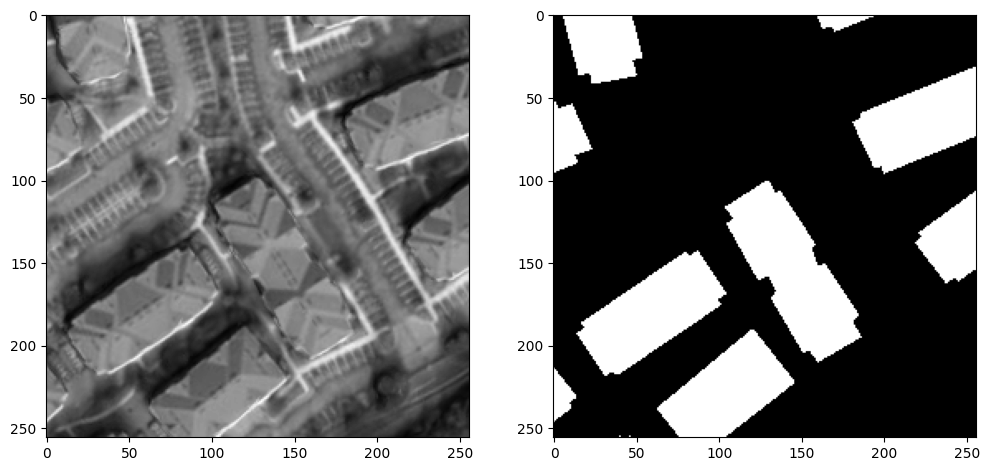

In [ ]:
#Sanity check, view few mages
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')

plt.show()

In [ ]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)  
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  
    x = Activation("relu")(x)

    return x




def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p



def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [ ]:
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                     

 rmalization)                   )                                                                 
                                                                                                  
 activation_8 (Activation)      (None, 16, 16, 1024  0           ['batch_normalization_8[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_9 (Conv2D)              (None, 16, 16, 1024  9438208     ['activation_8[0][0]']           
                                )                                                                 
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 16, 16, 1024  4096       ['conv2d_9[0][0]']               
 rmalization)                   )                                                                 
          

                                                                                                  
 conv2d_16 (Conv2D)             (None, 256, 256, 64  73792       ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_16 (BatchN  (None, 256, 256, 64  256        ['conv2d_16[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_16 (Activation)     (None, 256, 256, 64  0           ['batch_normalization_16[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_17

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=6,
                    validation_data=(X_test, y_test),
                    shuffle=False)

Epoch 1/5
300/300 [==============================] - 502s 2s/step - loss: 0.2214 - accuracy: 0.9175 - val_loss: 0.3148 - val_accuracy: 0.9020
Epoch 2/5
300/300 [==============================] - 459s 2s/step - loss: 0.1760 - accuracy: 0.9321 - val_loss: 0.2589 - val_accuracy: 0.9157
Epoch 3/5
300/300 [==============================] - 458s 2s/step - loss: 0.1548 - accuracy: 0.9405 - val_loss: 0.2702 - val_accuracy: 0.9002
Epoch 4/5
300/300 [==============================] - 458s 2s/step - loss: 0.1393 - accuracy: 0.9468 - val_loss: 0.1799 - val_accuracy: 0.9318
Epoch 5/5
300/300 [==============================] - 460s 2s/step - loss: 0.1290 - accuracy: 0.9509 - val_loss: 0.1717 - val_accuracy: 0.9377


## Save the model for future use

In [ ]:
model.save('model_6epochs.hdf5')

## Plot the training and validation accuracy and loss at each epoch


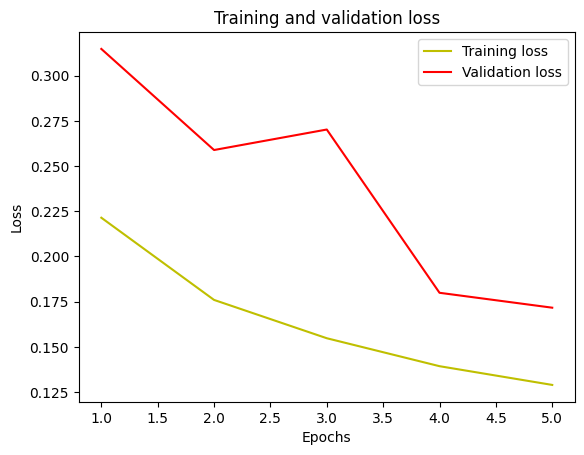

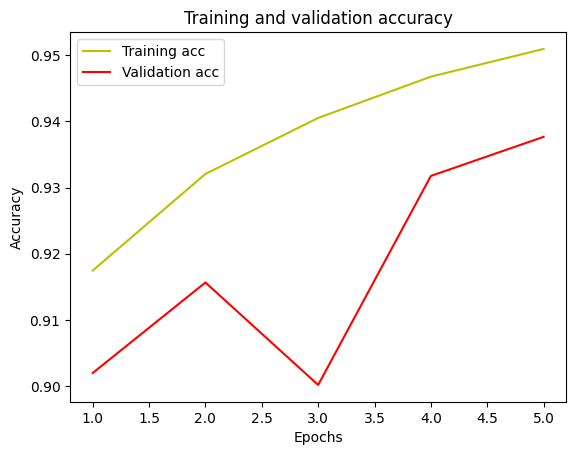

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Load previously saved model

In [ ]:
from keras.models import load_model
model = load_model("model_5epochs.hdf5", compile=False)

In [ ]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.3

38/38 [==============================] - 39s 1s/step


In [ ]:
from tensorflow.keras.metrics import MeanIoU

In [ ]:
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.6242094


# Prediction 

(1, 256, 256, 1)
1/1 [==============================] - 0s 61ms/step
(256, 256)


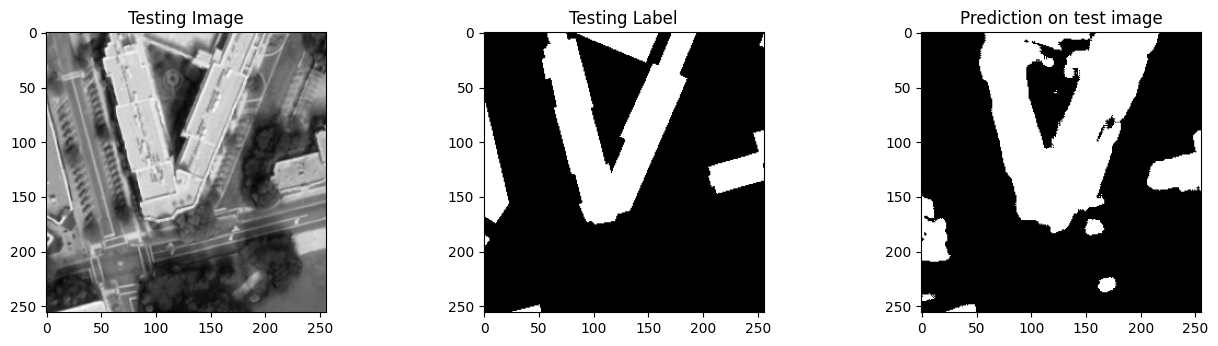

In [ ]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

(1, 256, 256, 1)
1/1 [==============================] - 0s 36ms/step
(256, 256)


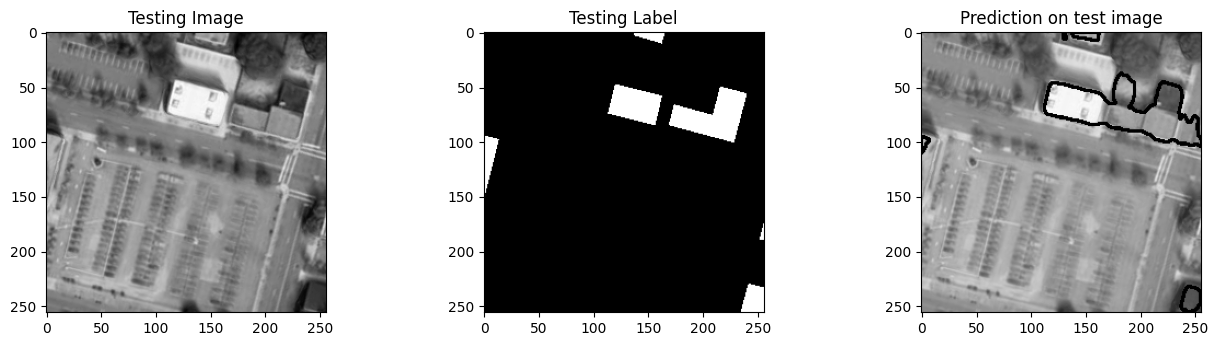

In [ ]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > threshold).astype(np.uint8)
print(prediction.shape)

# Find contours in the binary image
contours, _ = cv2.findContours(prediction, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on the original image
prediction_with_contours = cv2.drawContours(test_img.copy(), contours, -1, (0, 255, 0), 2)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction_with_contours, cmap='gray')
plt.show()

# Conclusion

> We obtained a IoU score of 62% after training the building extraction model for 5 epochs, demonstrating its effectiveness in analyzing satellite imagery.